# 데이터 전처리
- "id","person_prefer_f","person_prefer_g" column drop

In [1]:
from google import colab
colab.drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
!pip install catboost

     |████████████████████████████████| 76.3 MB 1.3 MB/s 


In [2]:
import os
import sys
import platform
import random
import math
from typing import List ,Dict, Tuple

import pandas as pd
import numpy as np
 
import sklearn 
from sklearn.model_selection import StratifiedKFold , KFold
from sklearn.metrics import f1_score 

from catboost import Pool,CatBoostClassifier

print(f"- os: {platform.platform()}")
print(f"- python: {sys.version}")
print(f"- pandas: {pd.__version__}")
print(f"- numpy: {np.__version__}")
print(f"- sklearn: {sklearn.__version__}")

ModuleNotFoundError: ignored

In [3]:
DATA_PATH = '/content/drive/MyDrive/데이콘/Jobcare_data/'
train_data = pd.read_csv(f'{DATA_PATH}train.csv')
test_data = pd.read_csv(f'{DATA_PATH}test.csv')
SEED = 42
code_d = pd.read_csv(f'{DATA_PATH}속성_D_코드.csv').iloc[:,:-1]
code_h = pd.read_csv(f'{DATA_PATH}속성_H_코드.csv')
code_l = pd.read_csv(f'{DATA_PATH}속성_L_코드.csv')

train_data.shape , test_data.shape

((501951, 35), (46404, 34))

In [6]:
code_d.columns

Index(['attribute_d', 'attribute_d_d', 'attribute_d_s', 'attribute_d_m'], dtype='object')

In [5]:
code_d.columns= ["attribute_d","attribute_d_d","attribute_d_s","attribute_d_m"]
code_h.columns= ["attribute_h","attribute_h_m","attribute_h_l"]
code_l.columns= ["attribute_l","attribute_l_d","attribute_l_s","attribute_l_m","attribute_l_l"]

In [ ]:
def merge_codes(df:pd.DataFrame,df_code:pd.DataFrame,col:str)->pd.DataFrame:#매개변수의 타입이 data.frame
#print(test.__annotations__) 참고로 import annotation해서 함수안 파라미터를 확인할 수 있다.
    df = df.copy()
    df_code = df_code.copy()
    df_code = df_code.add_prefix(f"{col}_")
    df_code.columns.values[0] = col
    return pd.merge(df,df_code,how="left",on=col)

In [ ]:
def preprocess_data(
                    df:pd.DataFrame,
                    is_train:bool = True,
                    cols_merge:List[Tuple[str,pd.DataFrame]] = []  ,
                    cols_equi:List[Tuple[str,str]]= [] ,
                    cols_drop:List[str] = ["id","person_prefer_f","person_prefer_g", "contents_open_dt"]
                    )->Tuple[pd.DataFrame,np.ndarray]:
    df = df.copy()

    y_data = None
    if is_train:
        y_data = df["target"].to_numpy()
        df = df.drop(columns="target")

    for col, df_code in cols_merge:
        df = merge_codes(df,df_code,col)

    cols = df.select_dtypes(bool).columns.tolist()
    df[cols] = df[cols].astype(int)

    for col1, col2 in cols_equi:
        df[f"{col1}_{col2}"] = (df[col1] == df[col2] ).astype(int)

    df = df.drop(columns=cols_drop)
    return (df , y_data)

In [ ]:
# 소분류 중분류 대분류 속성코드 merge 컬럼명 및 데이터 프레임 리스트
cols_merge = [
              ("person_prefer_d_1" , code_d),
              ("person_prefer_d_2" , code_d),
              ("person_prefer_d_3" , code_d),
              ("contents_attribute_d" , code_d),
              ("person_prefer_h_1" , code_h),
              ("person_prefer_h_2" , code_h),
              ("person_prefer_h_3" , code_h),
              ("contents_attribute_h" , code_h),
              ("contents_attribute_l" , code_l),
]

# 회원 속성과 콘텐츠 속성의 동일한 코드 여부에 대한 컬럼명 리스트
cols_equi = [

    ("contents_attribute_c","person_prefer_c"),
    ("contents_attribute_e","person_prefer_e"),

    ("person_prefer_d_2_attribute_d_s" , "contents_attribute_d_attribute_d_s"),
    ("person_prefer_d_2_attribute_d_m" , "contents_attribute_d_attribute_d_m"),
    ("person_prefer_d_2_attribute_d_d" , "contents_attribute_d_attribute_d_d"),
    ("person_prefer_d_3_attribute_d_s" , "contents_attribute_d_attribute_d_s"),
    ("person_prefer_d_3_attribute_d_m" , "contents_attribute_d_attribute_d_m"),
    ("person_prefer_d_3_attribute_d_d" , "contents_attribute_d_attribute_d_d"),

    ("person_prefer_h_1_attribute_h_m" , "contents_attribute_h_attribute_h_m"),#attribute_h_m ,l,none
    ("person_prefer_h_1_attribute_h_l" , "contents_attribute_h_attribute_h_l"),
    ("person_prefer_h_2_attribute_h_m" , "contents_attribute_h_attribute_h_m"),
    ("person_prefer_h_3_attribute_h_m" , "contents_attribute_h_attribute_h_m"),
    ("person_prefer_h_2_attribute_h_l" , "contents_attribute_h_attribute_h_l"),
    ("person_prefer_h_3_attribute_h_l" , "contents_attribute_h_attribute_h_l"),

]

# 학습에 필요없는 컬럼 리스트
cols_drop = ["id","person_prefer_f","person_prefer_g", "contents_open_dt"]

In [ ]:
x_train, y_train = preprocess_data(train_data, cols_merge = cols_merge , cols_equi= cols_equi , cols_drop = cols_drop)
x_test, _ = preprocess_data(test_data,is_train = False, cols_merge = cols_merge , cols_equi= cols_equi  , cols_drop = cols_drop)
x_train.shape , y_train.shape , x_test.shape

((501951, 68), (501951,), (46404, 68))

# 검증 데이터 나누기
- 0.8:0.2 비율

In [ ]:
from sklearn.model_selection import train_test_split
x_train, x_valid, y_train, y_valid = train_test_split(x_train, y_train, test_size=0.2)

In [ ]:
len(x_train)

401560

In [ ]:
len(x_valid)

100391

In [ ]:
x_train.head()

,d_l_match_yn,d_m_match_yn,d_s_match_yn,h_l_match_yn,h_m_match_yn,h_s_match_yn,person_attribute_a,person_attribute_a_1,person_attribute_b,person_prefer_c,person_prefer_d_1,person_prefer_d_2,person_prefer_d_3,person_prefer_e,person_prefer_h_1,person_prefer_h_2,person_prefer_h_3,contents_attribute_i,contents_attribute_a,contents_attribute_j_1,contents_attribute_j,contents_attribute_c,contents_attribute_k,contents_attribute_l,contents_attribute_d,contents_attribute_m,contents_attribute_e,contents_attribute_h,person_rn,contents_rn,contents_open_dt,person_prefer_d_1_attribute_d_d,person_prefer_d_1_attribute_d_s,person_prefer_d_1_attribute_d_m,person_prefer_d_2_attribute_d_d,person_prefer_d_2_attribute_d_s,person_prefer_d_2_attribute_d_m,person_prefer_d_3_attribute_d_d,person_prefer_d_3_attribute_d_s,person_prefer_d_3_attribute_d_m,contents_attribute_d_attribute_d_d,contents_attribute_d_attribute_d_s,contents_attribute_d_attribute_d_m,person_prefer_h_1_attribute_h_m,person_prefer_h_1_attribute_h_l,person_prefer_h_2_attribute_h_m,person_prefer_h_2_attribute_h_l,person_prefer_h_3_attribute_h_m,person_prefer_h_3_attribute_h_l,contents_attribute_h_attribute_h_m,contents_attribute_h_attribute_h_l,contents_attribute_l_attribute_l_d,contents_attribute_l_attribute_l_s,contents_attribute_l_attribute_l_m,contents_attribute_l_attribute_l_l,contents_attribute_c_person_prefer_c,contents_attribute_e_person_prefer_e,person_prefer_d_2_attribute_d_s_contents_attribute_d_attribute_d_s,person_prefer_d_2_attribute_d_m_contents_attribute_d_attribute_d_m,person_prefer_d_2_attribute_d_d_contents_attribute_d_attribute_d_d,person_prefer_d_3_attribute_d_s_contents_attribute_d_attribute_d_s,person_prefer_d_3_attribute_d_m_contents_attribute_d_attribute_d_m,person_prefer_d_3_attribute_d_d_contents_attribute_d_attribute_d_d,person_prefer_h_1_attribute_h_m_contents_attribute_h_attribute_h_m,person_prefer_h_1_attribute_h_l_contents_attribute_h_attribute_h_l,person_prefer_h_2_attribute_h_m_contents_attribute_h_attribute_h_m,person_prefer_h_3_attribute_h_m_contents_attribute_h_attribute_h_m,person_prefer_h_2_attribute_h_l_contents_attribute_h_attribute_h_l,person_prefer_h_3_attribute_h_l_contents_attribute_h_attribute_h_l
263237,0,0,0,1,1,1,2,0,5,2,1227,1086,857,3,93,79,189,3,3,5,1,3,2,1611,122,1,3,93,969744,271991,2020-06-12 13:59:23,1227,1227,1227,1086,1086,1053,854,853,824,114,109,56,397,92,385,78,463,188,397,92,1610,1606,1605,2016,0,1,0,0,0,0,0,0,1,1,0,0,0,0
337004,1,1,0,0,0,0,1,2,2,1,114,181,175,6,125,28,27,2,1,5,1,1,2,953,117,1,5,28,693436,25656,2020-01-15 01:43:27,114,109,56,175,152,56,175,152,56,114,109,56,411,94,340,3,339,3,340,3,952,951,930,2009,1,0,0,1,0,0,1,0,0,0,1,0,1,1
267277,0,0,0,0,0,0,1,2,4,1,966,372,299,4,152,95,2,3,1,10,2,1,2,612,372,2,6,127,813498,426701,2020-03-16 13:28:39,962,961,927,369,368,297,299,298,297,369,368,297,434,149,398,94,315,1,413,94,609,606,573,2006,1,0,1,1,1,0,1,0,0,0,0,0,1,0
499370,0,0,0,1,0,0,1,6,2,1,857,694,1227,3,4,95,59,2,3,5,1,3,2,906,724,5,6,6,84009,13747,2020-05-01 22:20:10,854,853,824,694,691,690,1227,1227,1227,724,717,716,316,3,398,94,368,58,318,3,905,902,901,2008,0,0,0,0,0,0,0,0,0,1,0,0,0,0
138190,1,1,0,0,0,0,2,0,2,5,1029,1027,1003,5,4,95,59,1,1,5,1,1,2,534,1027,1,5,138,56481,317457,2020-05-11 13:34:54,1027,1026,1000,1027,1026,1000,1003,1001,1000,1027,1026,1000,316,3,398,94,368,58,421,94,529,528,527,2006,0,1,1,1,1,0,1,0,0,0,0,0,1,0


In [ ]:
cat_features = x_train.columns[x_train.nunique() > 2].tolist()

학습 파라미터, n_splits : 데이터 분할 수, iteration : 반복수 , patience : 최소 인내 수(맥스값추출할때 필수)

In [ ]:
is_holdout = False
#기존 train과 val데이터 분할 안함
n_splits = 5
#데이터 분할 수 k-fold 검정
iterations = 3000
#반복수
patience = 50
#최소 인내수
cv = KFold(n_splits=n_splits, shuffle=True, random_state=SEED)

### Learning rate란
경사하강법 알고리즘에서 기울기에 곱하는 스칼라로 Local minimum에 효율적으로 도달할 수 있도록 세팅해야한다.
<학습률이 크면> : 데이터가 무질서하게 이탈, 최저점에 수렴불가
<학습률이 작으면> : 학습시간이 너무 오래걸려 최저점에 수렴불가
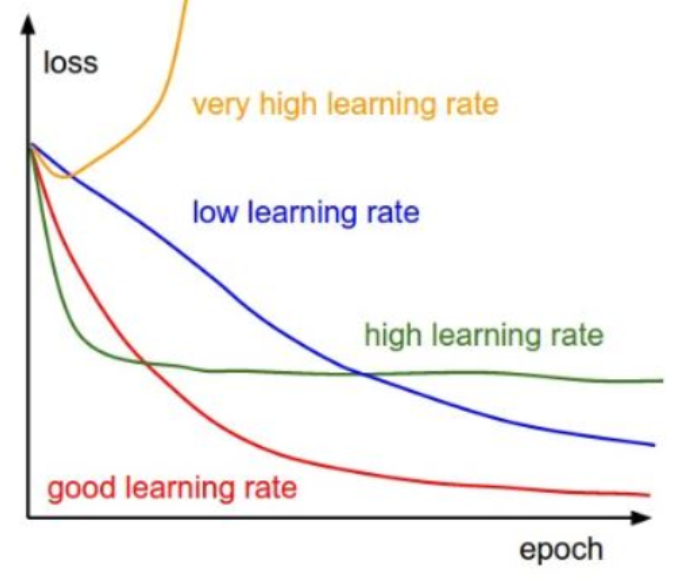

### 기존 catboost

In [ ]:
scores = []
models = []


for tri, vai in cv.split(x_train):
    print("="*50)
    preds = []

    model = CatBoostClassifier(iterations=iterations,
                               task_type="GPU",random_state = SEED,
                               boosting_type= 'Ordered',
                               eval_metric="F1",
                               cat_features=cat_features,
                               one_hot_max_size=3)
    #one_hot_max_size : ts할지 원핫 인코딩할지 원래 4였는데 말이 안됨
    model.fit(x_train.iloc[tri], y_train[tri], 
            eval_set=[(x_train.iloc[vai], y_train[vai])], 
            early_stopping_rounds=patience ,
            verbose = 100
        )
    
    models.append(model)
    scores.append(model.get_best_score()["validation"]["F1"])
    if is_holdout:
        break    

Custom logger is already specified. Specify more than one logger at same time is not thread safe.

Learning rate set to 0.027664


CatBoostError: ignored

In [ ]:
print(scores)
print(np.mean(scores))

In [ ]:
threshold = 0.385
pred_list = []
scores = []
for i,(tri, vai) in enumerate( cv.split(x_train) ):
    pred = models[i].predict_proba(x_train.iloc[vai])[:, 1]
    pred = np.where(pred >= threshold , 1, 0)
    score = f1_score(y_train[vai],pred)
    scores.append(score)
    pred = models[i].predict_proba(x_test)[:, 1]
    pred_list.append(pred)
print(scores)
print(np.mean(scores))

In [ ]:
pred = np.mean( pred_list , axis = 0 )
pred = np.where(pred >= threshold , 1, 0)

In [ ]:
sample_submission = pd.read_csv(f'{DATA_PATH}sample_submission.csv')
sample_submission['target'] = pred
sample_submission.to_csv('/content/drive/MyDrive/dacon/ROY/sample_submission1205.csv', index=False)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

### Optuna 진행 따로 파일을 만들어 정리 하겠습니다.


In [ ]:
import catboost as cb
import optuna
from sklearn.model_selection import train_test_split

In [ ]:
# create trial function
OPTUNA_OPTIMIZATION = True

def objective(trial):
    train_x, valid_x, train_y, valid_y = train_test_split(x_train,y_train, test_size=0.3)
    
    params = {
        'iterations':trial.suggest_int("iterations", 1000, 20000),
        'objective': trial.suggest_categorical('objective', ['Logloss', 'CrossEntropy']),
        'bootstrap_type': trial.suggest_categorical('bootstrap_type', ['Bayesian', 'Bernoulli', 'MVS']),
        'od_wait':trial.suggest_int('od_wait', 500, 2000),
        'learning_rate' : trial.suggest_uniform('learning_rate',0.01,1),
        'reg_lambda': trial.suggest_uniform('reg_lambda',1e-5,100),
        'random_strength': trial.suggest_uniform('random_strength',10,50),
        'depth': trial.suggest_int('depth',1,15),
        'min_data_in_leaf': trial.suggest_int('min_data_in_leaf',1,30),
        'leaf_estimation_iterations': trial.suggest_int('leaf_estimation_iterations',1,15),
        'verbose': False,
        'task_type' : 'GPU',
        'devices' : '0'
    }
    
    if params['bootstrap_type'] == 'Bayesian':
        params['bagging_temperature'] = trial.suggest_float('bagging_temperature', 0, 10)
    elif params['bootstrap_type'] == 'Bernoulli':
        params['subsample'] = trial.suggest_float('subsample', 0.1, 1)
    
    model = CatBoostClassifier(**params)
    model.fit(
        train_x, train_y, eval_set=[(valid_x, valid_y)],
        early_stopping_rounds=100,
        use_best_model=True
    )
    
    # validation prediction

    preds = model.predict(valid_x)
    pred_labels = np.rint(preds)
    score = f1_score(valid_y, pred_labels)
    return score

In [ ]:
!pip install optuna

In [ ]:
study = optuna.create_study(
    direction='maximize',
    study_name='CatbClf'
)

study.optimize(
    objective, 
    n_trials=100
)

[I 2022-01-04 13:02:23,373] A new study created in memory with name: CatbClf
[W 2022-01-04 13:02:23,656] Trial 0 failed because of the following error: CatBoostError('Bad value for num_feature[non_default_doc_idx=0,feature_idx=30]="2020-08-06 10:08:30": Cannot convert \'b\'2020-08-06 10:08:30\'\' to float')
Traceback (most recent call last):
  File "_catboost.pyx", line 2167, in _catboost.get_float_feature
  File "_catboost.pyx", line 1125, in _catboost._FloatOrNan
  File "_catboost.pyx", line 949, in _catboost._FloatOrNanFromString
TypeError: Cannot convert 'b'2020-08-06 10:08:30'' to float

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/optuna/study/_optimize.py", line 213, in _run_trial
    value_or_values = func(trial)
  File "<ipython-input-29-53a2d414f829>", line 32, in objective
    use_best_model=True
  File "/usr/local/lib/python3.7/dist-packages/catboost/core.py", line 4718

CatBoostError: ignored

In [ ]:
Best_params = study.best_trial.params
print(f"Best Trial: {study.best_trial.value}")
print(f"Best Params: {study.best_trial.params}")

### Catboostclassifier 진행

In [ ]:
best_params = {'iterations': 2518, 'objective': 'CrossEntropy', 
               'bootstrap_type': 'Bernoulli', 'od_wait': 542, 'learning_rate': 0.21755292143147012,
               'reg_lambda': 56.967976655361504, 'random_strength': 43.729162984090486, 'depth': 8,
               'min_data_in_leaf': 17, 'leaf_estimation_iterations': 12,
               'one_hot_max_size': 2, 'subsample': 0.2764159367039591,
               "cat_features": cat_features,
               "eval_metric":'F1',
               'task_type' : 'GPU'
               }

In [ ]:
scores = []
models = []


for tri, vai in cv.split(x_train):
    preds = []
    model = CatBoostClassifier(**best_params)
    model.fit(x_train.iloc[tri], y_train[tri],
            eval_set=[(x_train.iloc[vai], y_train[vai])],
            early_stopping_rounds = 500,
            verbose=100
        )
    models.append(model)
    scores.append(model.get_best_score()["validation"]["F1"])
    if is_holdout:
        break    

Custom logger is already specified. Specify more than one logger at same time is not thread safe.

CatBoostError: ignored

# eli5 라이브러리를 이용한 변수 중요도 파악
- Permutation Feature Importance

In [ ]:
!pip install eli5

     |████████████████████████████████| 106 kB 5.0 MB/s 


contents_open_dt 변수 제거해야 함!!

In [ ]:
x_train = x_train.drop(columns="contents_open_dt")
x_valid = x_valid.drop(columns="contents_open_dt")

KeyError: ignored

In [ ]:
import eli5
from eli5.sklearn import PermutationImportance

model=CatBoostClassifier(silent=True, random_state=0).fit(x_train, y_train)


In [ ]:
perm = PermutationImportance(model, random_state=1).fit(x_valid, y_valid)
eli5.show_weights(perm, feature_names = x_valid.columns.tolist(), top=100)

Weight,Feature
0.0116 ± 0.0013,contents_attribute_d
0.0083 ± 0.0011,contents_attribute_e
0.0071 ± 0.0010,contents_attribute_j_1
0.0069 ± 0.0008,contents_attribute_d_attribute_d_d
0.0059 ± 0.0008,person_prefer_e
0.0059 ± 0.0004,d_l_match_yn
0.0057 ± 0.0004,d_m_match_yn
0.0048 ± 0.0009,person_prefer_d_2
0.0046 ± 0.0008,contents_attribute_l_attribute_l_s
0.0044 ± 0.0009,contents_attribute_a


In [ ]:
perm = PermutationImportance(model, random_state=2).fit(x_valid, y_valid)
eli5.show_weights(perm, feature_names = x_valid.columns.tolist(), top=100)

Weight,Feature
0.0128 ± 0.0009,contents_attribute_d
0.0089 ± 0.0016,contents_attribute_e
0.0077 ± 0.0006,contents_attribute_j_1
0.0072 ± 0.0008,contents_attribute_d_attribute_d_d
0.0062 ± 0.0005,person_prefer_e
0.0059 ± 0.0009,d_m_match_yn
0.0056 ± 0.0013,d_l_match_yn
0.0053 ± 0.0014,person_prefer_d_2
0.0045 ± 0.0007,contents_attribute_l_attribute_l_s
0.0042 ± 0.0006,contents_attribute_a


In [ ]:
perm = PermutationImportance(model, random_state=3).fit(x_valid, y_valid)
eli5.show_weights(perm, feature_names = x_valid.columns.tolist(), top=100)

Weight,Feature
0.0168 ± 0.0014,contents_attribute_d
0.0147 ± 0.0007,contents_attribute_d_attribute_d_d
0.0086 ± 0.0012,contents_attribute_e
0.0077 ± 0.0014,contents_attribute_d_attribute_d_s
0.0067 ± 0.0011,contents_attribute_j_1
0.0064 ± 0.0006,person_prefer_e
0.0053 ± 0.0009,d_l_match_yn
0.0053 ± 0.0011,d_m_match_yn
0.0048 ± 0.0007,contents_attribute_a
0.0046 ± 0.0006,contents_attribute_l
